这里应该做个嘲讽捏造数据的模型，优化p值使得不应该显著的项而显著。顺便练练pytorch0.4的新api

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline

In [2]:
import pandas as pd

In [13]:
import torch
import torch.optim as optim

In [4]:
_X = np.random.random(10)
_Y = np.random.random(10)

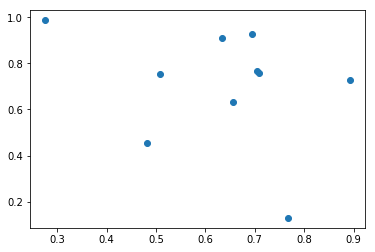

In [5]:
plt.plot(_X,_Y,'o')
plt.show()

In [6]:
df = pd.DataFrame(dict(X=_X,Y=_Y))
smf.ols('Y ~ X',data=df).fit().summary()

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.8205
Date:                Sun, 29 Apr 2018   Prob (F-statistic):              0.392
Time:                        08:53:46   Log-Likelihood:                0.55222
No. Observations:                  10   AIC:                             2.896
Df Residuals:                       8   BIC:                             3.501
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9888      0.324      3.053      0.016       0.242       1.736
X             -0.4491      0.496     -0.906      0.392      -1.593       0.694
==============================================================================
Omnibus:                        4.849   Durbin-Watson:                   2.323
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                2.185
Skew:                          -1.143   Prob(JB):                        0.335
Kurtosis:                       3.138   Cond. No.                         8.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
sm_res = smf.ols('Y ~ X',data=df).fit()

In [8]:
sm_res.pvalues

Intercept    0.015741
X            0.391505
dtype: float64

In [7]:
X = torch.tensor(_X, dtype=torch.float32)
Y = torch.tensor(_Y, dtype=torch.float32)
a = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)

Yhat = a + b * X
loss = torch.sum((Y-Yhat)**2)

In [8]:
loss

tensor(3.0031)

In [9]:
loss.backward()

In [10]:
a.grad

tensor(-9.7974)

In [11]:
b.grad

tensor(-3.0491)

In [13]:
optimizer = optim.SGD([a,b],lr=0.0001)

In [14]:
for epoch in range(100):
    optimizer.zero_grad()
    Yhat = a + b * X
    loss = torch.sum((Y-Yhat)**2)
    loss.backward()
    #print(loss)
    optimizer.step()

In [15]:
a

tensor(1.00000e-02 *
       8.8053)

In [16]:
b

tensor(1.00000e-02 *
       2.7255)

In [17]:
loss

tensor(2.1578)

看起来梯度下降ols本身没有偏差，这波把X，Y也纳入优化但这种修改会增加loss

In [18]:
X_origin = torch.tensor(_X, dtype=torch.float32)
X = torch.tensor(_X, requires_grad=True, dtype=torch.float32)
Y_origin = torch.tensor(_Y, dtype=torch.float32)
Y = torch.tensor(_Y, requires_grad=True, dtype=torch.float32)

a = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)

In [19]:
optimizer = optim.SGD([X,Y,a,b], lr=0.01)

In [20]:
for epoch in range(100):
    optimizer.zero_grad()
    Yhat = a + b * X
    loss = torch.sum((Y-Yhat)**2) + torch.sum((X - X_origin)**2) + torch.sum((Y-Y_origin)**2)
    loss.backward()
    #print(loss)
    optimizer.step()

In [21]:
a

tensor(0.4511)

In [22]:
b

tensor(1.00000e-02 *
       9.6368)

In [23]:
X - X_origin

tensor(1.00000e-02 *
       [-2.0709,  0.3190,  1.3435,  1.2645, -1.2626, -0.5244,  2.0796,
        -0.2172,  0.4974, -0.9376])

In [24]:
Y - Y_origin

tensor([ 0.2009, -0.0343, -0.1345, -0.1268,  0.1216,  0.0490, -0.2071,
         0.0187, -0.0513,  0.0894])

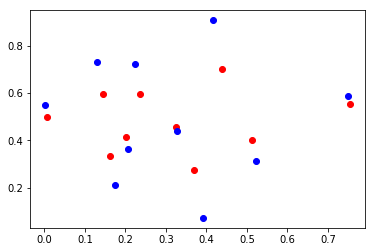

In [25]:
plt.plot(X.detach().numpy(), Y.detach().numpy(), 'o',color='red')
plt.plot(X_origin.numpy(), Y_origin.numpy(), 'o',color='blue')
plt.show()

值得注意的一点是梯度下降法算出来的东西本身是求不了梯度的，从而t统计量依赖的参数估计量如果是梯度下降算出来的（虽然可以解析的表示，
但其实的确是迭代算出来的），则我们不能求出t统计量对X，Y的梯度。

In [26]:
X = torch.ones(_X.shape[0], 2, requires_grad=True)
X[:,1] = torch.tensor(_X, dtype=torch.float32)

In [27]:
X

tensor([[ 1.0000,  0.3911],
        [ 1.0000,  0.7503],
        [ 1.0000,  0.1303],
        [ 1.0000,  0.2226],
        [ 1.0000,  0.1737],
        [ 1.0000,  0.2074],
        [ 1.0000,  0.4167],
        [ 1.0000,  0.3269],
        [ 1.0000,  0.0024],
        [ 1.0000,  0.5219]])

In [28]:
Y = torch.tensor(_Y, dtype=torch.float32, requires_grad=True)

In [29]:
# https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf
beta = torch.inverse(torch.transpose(X,0,1) @ X) @ torch.transpose(X,0,1) @ Y #正规方程，怎么感觉好像这计算开销也没记忆中那么大...
beta

tensor([ 0.5013, -0.0364])

In [30]:
e = Y - X @ beta
e

tensor([-0.4153,  0.1145,  0.2346,  0.2315, -0.2830, -0.1300,  0.4220,
        -0.0518,  0.0469, -0.1695])

In [31]:
n = X.shape[0]
k = X.shape[1]
n,k,n-k

(10, 2, 8)

In [32]:
# https://stats.stackexchange.com/questions/44838/how-are-the-standard-errors-of-coefficients-calculated-in-a-regression

sigma_square = (e @ e)/(n-k)
sigma_square

tensor(1.00000e-02 *
       7.5355)

In [33]:
var_bar = sigma_square * torch.inverse(torch.transpose(X,0,1) @ X)
var_bar

tensor([[ 0.0252, -0.0563],
        [-0.0563,  0.1792]])

In [34]:
se = torch.sqrt(torch.diag(var_bar))
se

tensor([ 0.1589,  0.4233])

In [35]:
t_test = (beta - 0.0)/se
t_test

tensor([ 3.1552, -0.0859])

In [47]:
print('real p-value\n',sm_res.pvalues)

real p-value
 Intercept    0.013492
X            0.933675
dtype: float64


In [37]:
p_value = torch.distributions.Normal(0,1).cdf(-torch.abs(t_test)) *2
p_value

tensor([ 0.0016,  0.9316])

pytorch现在没提供student t的cdf，看了看jstat的实现也依赖一个迭代的计算，对梯度计算不利（虽然也不是一定不能用），所以这里做个小近似，
调整正态分布的方差来解决。

考虑t分布方差为$\frac{v}{v-2}$

In [38]:
p_value = torch.distributions.Normal(0,np.sqrt((n-k)/(n-k-2))).cdf(-torch.abs(t_test)) *2
p_value

tensor([ 0.0063,  0.9407])

并不是非常准确，下面手动搞个近似

这里用的是《统计计算》的beta分布函数I的连分数展开，t分布的分布函数可以通过一个不是很明显的变换变成beta分布函数的形式。

beta函数的对数

$$
\log \mathrm{B}(a,b) = \log \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)} = \log \Gamma(a) + \log \Gamma(b) - \log \Gamma(a+b)
$$

t分布分布函数与beta分布分布函数之关系

$$
T(t \mid n) = \begin{cases}
1 - \frac{1}{2} I_x(\frac{n}{2},\frac{1}{2}) & t>0 \\
\frac{1}{2} I_x(\frac{n}{2},\frac{1}{2}) & t \le 0
\end{cases}
$$

其中
$$
x = \frac{n}{n+t^2}
$$

beta分布分布函数

\begin{align}
I_x(a,b) &= \frac{x^a(1-x)^{b-1}}{\mathrm{B}(a,b)a} \left(
1 + \sum_{k=1}^{\infty}\frac{(b-1)\dots(b-k)}{(a+1)\dots(a+k)}\left( \frac{x}{1-x} \right)^k
\right) \\
&= \exp( a \log(x) +(b-1)\log(1-x)-\log(\mathrm{B}(a,b)) -\log(a) )\left(
1 + \sum_{k=1}^\infty \exp( \sum_{i=1}^k \log(b-i) - \sum_{i=1}^k \log(a+i) + k(\log x - \log(1-x))  )
\right)
\end{align}


In [39]:
def outer(X,Y):
    return X.repeat(Y.shape[0],1).transpose(0,1) * Y

In [53]:
def log_beta(a,b):
    return torch.lgamma(a) + torch.lgamma(b) - torch.lgamma(a+b)


def ibeta(x,a,b,n=5):
    log,exp,cumsum,cumprod,sum = torch.log,torch.exp,torch.cumsum,torch.cumprod,torch.sum
    left = exp(a*log(x) + (b-1)*log(1-x) - log_beta(a,b) - log(a))
    xx = log(x) - log(1.0-x)
    #xx = x/(1-x)
    k = torch.arange(1,n+1,dtype=torch.float32)
    right = 1.0 + sum( (outer(k,xx)).transpose(0,1) * cumprod((b - k)/(a + k), 0) , dim=1)
    return left * right

def student_t_cdf(t, n):
    # 限制 t<0
    x = n/(n+t**2)
    return 0.5 * ibeta(x, torch.tensor(0.5*n), torch.tensor(0.5))

In [54]:
p_value = student_t_cdf(-torch.abs(t_test), n-k) *2
p_value

tensor([ 0.0147,  4.5269])

In [64]:
#X = torch.tensor(np.c_[np.ones(_X.shape[0]),_X], dtype=torch.float32, requires_grad=True)
X = torch.tensor(np.c_[np.ones(_X.shape[0]),_X], dtype=torch.float32)
Y = torch.tensor(_Y, dtype=torch.float32, requires_grad=True)

Y_origin = torch.tensor(_Y, dtype=torch.float32)

In [65]:
optimizer = optim.SGD([Y],lr=0.01)
for epoch in range(100):
    optimizer.zero_grad()
    beta = torch.inverse(torch.transpose(X,0,1) @ X) @ torch.transpose(X,0,1) @ Y
    e = Y - X @ beta
    n = X.shape[0]
    k = X.shape[1]
    sigma_square = (e @ e)/(n-k)
    var_bar = sigma_square * torch.inverse(torch.transpose(X,0,1) @ X)
    se = torch.sqrt(torch.diag(var_bar))
    t_test = (beta - 0.0)/se
    p_value = torch.distributions.Normal(0,np.sqrt((n-k)/(n-k-2))).cdf(-torch.abs(t_test)) *2 #这步是近似计算，因为基于迭代解p值不好求梯度
    
    loss = p_value[1]  + torch.sum((Y-Y_origin)**2)
    loss.backward()
    optimizer.step()

In [66]:
Y

tensor([ 0.1526,  0.3026,  0.7666,  0.7079,  0.3783,  0.4645,  0.7221,
         0.4460,  0.7139,  0.2441])

In [67]:
Y_origin

tensor([ 0.0718,  0.5885,  0.7311,  0.7247,  0.2120,  0.3638,  0.9082,
         0.4376,  0.5481,  0.3128])

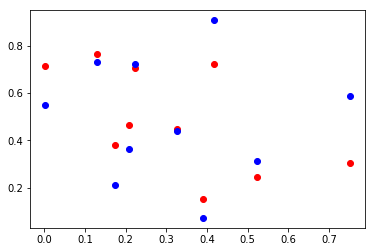

In [69]:
plt.plot(_X, Y.detach().numpy(), 'o',color='red')
plt.plot(_X, Y_origin.numpy(), 'o',color='blue')
plt.show()

In [70]:
def show_change(x_old, y_old, x_new, y_new):
    dx = x_new - x_old
    dy = y_new - y_old
    plt.plot(x_old, y_old, 'o', color='red')
    #plt.show()
    plt.plot(x_new, y_new, 'o', color='blue')
    for i in range(x_old.shape[0]):
        plt.arrow(x_old[i], y_old[i], dx[i], dy[i], head_width=0.02)
    plt.show()
    plt.plot(x_old, y_old, 'o', color='red')
    plt.show()
    plt.plot(x_new, y_new, 'o', color='blue')
    plt.show()

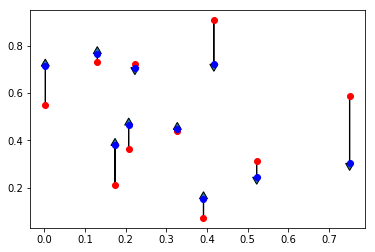

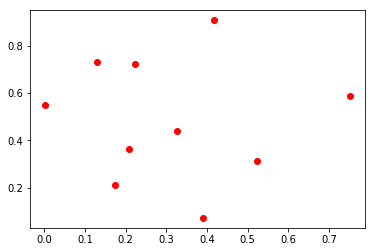

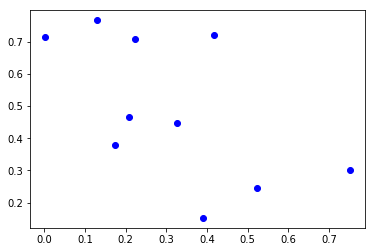

In [96]:
show_change(_X,_Y,_X,Y.detach().numpy())
plt.show()

In [87]:
df_new = df.copy()
df_new['Y'] = Y.detach().numpy()

In [88]:
res_new_df = smf.ols('Y ~ X',data=df_new).fit()
res_new_df.summary()

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     4.293
Date:                Sun, 29 Apr 2018   Prob (F-statistic):             0.0720
Time:                        08:30:41   Log-Likelihood:                 3.4372
No. Observations:                  10   AIC:                            -2.874
Df Residuals:                       8   BIC:                            -2.269
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6826      0.111      6.147      0.000       0.427       0.939
X             -0.6130      0.296     -2.072      0.072      -1.295       0.069
==============================================================================
Omnibus:                        0.173   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.917   Jarque-Bera (JB):                0.364
Skew:                           0.004   Prob(JB):                        0.834
Kurtosis:                       2.066   Cond. No.                         5.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
n = _X.shape[0]
k = 2

for i in range(n):
    X = torch.tensor(np.c_[np.ones(_X.shape[0]),_X], dtype=torch.float32)
    #Y = torch.tensor(_Y, dtype=torch.float32)
    y = torch.tensor(_Y[i], dtype=torch.float32, requires_grad=True)
    #Y[i] = y
    
    optimizer = optim.SGD([y],lr=0.01)
    for epoch in range(100):
        optimizer.zero_grad()
        
        Y = torch.tensor(_Y, dtype=torch.float32) #把Y放外面会出又要求梯度又求过一次梯度那个错误
        Y[i] = y
        
        beta = torch.inverse(torch.transpose(X,0,1) @ X) @ torch.transpose(X,0,1) @ Y
        e = Y - X @ beta
        sigma_square = (e @ e)/(n-k)
        var_bar = sigma_square * torch.inverse(torch.transpose(X,0,1) @ X)
        se = torch.sqrt(torch.diag(var_bar))
        t_test = (beta - 0.0)/se
        p_value = torch.distributions.Normal(0,np.sqrt((n-k)/(n-k-2))).cdf(-torch.abs(t_test)) *2 #这步是近似计算，因为基于迭代解p值不好求梯度

        loss = p_value[1] # + torch.sum((Y-Y_origin)**2)
        loss.backward()
        optimizer.step()
    
    df_new = df.copy()
    df_new['Y'] = Y.detach().numpy()
    res_new_df = smf.ols('Y ~ X',data=df_new).fit()
    res_new_df.summary()
    print(i,res_new_df.pvalues)

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


0 Intercept    0.016101
X            0.390765
dtype: float64
1 Intercept    0.002845
X            0.135966
dtype: float64
2 Intercept    0.014920
X            0.329069
dtype: float64
3 Intercept    0.010344
X            0.289400
dtype: float64
4 Intercept    0.005439
X            0.098849
dtype: float64
5 Intercept    0.005388
X            0.093430
dtype: float64
6 Intercept    0.012415
X            0.296039
dtype: float64
7 Intercept    0.014011
X            0.373870
dtype: float64
8 Intercept    0.019082
X            0.388320
dtype: float64
9 Intercept    0.014873
X            0.332778
dtype: float64


In [61]:
def optim_Y(optim_i, _X, _Y, target_X_i):
    # 这里假设_X是完整的设计矩阵，包括全1列.optim_i是要被优化的i，target_X_i是用来优化p-value的列
    n = _X.shape[0]
    k = _X.shape[1]
    
    #X = torch.tensor(np.c_[np.ones(_X.shape[0]),_X], dtype=torch.float32)
    X = torch.tensor(_X, dtype=torch.float32)
    #Y = torch.tensor(_Y, dtype=torch.float32)
    y = torch.tensor(_Y[optim_i], dtype=torch.float32, requires_grad=True)
    #Y[i] = y
    
    optimizer = optim.SGD([y],lr=0.01)
    for epoch in range(100):
        optimizer.zero_grad()
        
        Y = torch.tensor(_Y, dtype=torch.float32) #把Y放外面会出又要求梯度又求过一次梯度那个错误
        Y[optim_i] = y
        
        beta = torch.inverse(torch.transpose(X,0,1) @ X) @ torch.transpose(X,0,1) @ Y
        e = Y - X @ beta
        sigma_square = (e @ e)/(n-k)
        var_bar = sigma_square * torch.inverse(torch.transpose(X,0,1) @ X)
        se = torch.sqrt(torch.diag(var_bar))
        t_test = (beta - 0.0)/se
        p_value = torch.distributions.Normal(0,np.sqrt((n-k)/(n-k-2))).cdf(-torch.abs(t_test)) *2 #这步是近似计算，因为基于迭代解p值不好求梯度

        loss = p_value[target_X_i] # + torch.sum((Y-Y_origin)**2)
        loss.backward()
        optimizer.step()
    
    return y.item(),loss.item()
    
def select_Y(_X,_Y,target_X_i,exclude=None):
    n = _X.shape[0]
    k = _X.shape[1]
    
    if exclude is None:
        exclude = set()
    else:
        exclude = set(exclude)
    
    res = []
    for i in set(range(n)) - exclude:
        y,loss = optim_Y(i, _X, _Y, target_X_i)
        __Y = _Y.copy()
        __Y[i] = y
        res.append((i, y, sm.OLS(__Y,_X).fit().pvalues[target_X_i],loss)) # 位置id，对应的新取值,对应的精确值，对应的拟合p值
    
    #return min(res,key=lambda tup:tup[2])
    return res

In [54]:
select_Y(np.c_[np.ones(_X.shape[0]),_X],_Y,1)

[(0, 0.6057834029197693, 0.3907617075435684, 0.4320213794708252),
 (1, 0.9506849646568298, 0.13552128953031298, 0.15111225843429565),
 (2, 0.5124577283859253, 0.3288507513093427, 0.3681017756462097),
 (3, 0.6101948022842407, 0.2890757322625891, 0.325813889503479),
 (4, 0.2106517106294632, 0.09840055601065092, 0.10588997602462769),
 (5, 1.5046006441116333, 0.09294015798293309, 0.09921258687973022),
 (6, 1.0574439764022827, 0.29572597738397266, 0.3329622745513916),
 (7, 0.777508556842804, 0.3737957891035397, 0.4147229790687561),
 (8, 0.0733516588807106, 0.38829767281958094, 0.4295269250869751),
 (9, 0.5269665718078613, 0.33257139535348335, 0.37200599908828735)]

In [64]:
def greedy_make_up(limit,_X,_Y,target_X_i):
    selected = []
    _Y = _Y.copy()
    trace = [sm.OLS(_Y,_X).fit().pvalues[target_X_i]]
    for i in range(limit):
        i,y,pvalue,pvaluehat = min(select_Y(_X, _Y, target_X_i, exclude=selected),key=lambda term:term[2])
        selected.append(i)
        trace.append(pvalue)
        _Y[i] = y
    return _Y,trace,selected

In [65]:
greedy_make_up(3,np.c_[np.ones(_X.shape[0]),_X],_Y,1)

(array([0.63269073, 0.59375399, 0.75937491, 0.92769326, 0.48062742,
        1.50460064, 0.75267548, 0.90939238, 0.13027563, 0.76648336]),
 [0.39150539184981836,
  0.09294015798293309,
  0.03917119129134167,
  0.02095969347330555],
 [5, 4, 1])

In [67]:
Y_makeup, trace,selected = greedy_make_up(2,np.c_[np.ones(_X.shape[0]),_X],_Y,1)

In [68]:
Y_makeup - _Y

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.24669301,
        0.51789824,  0.        ,  0.        ,  0.        ,  0.        ])

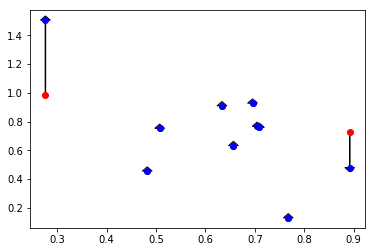

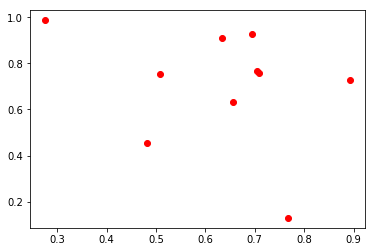

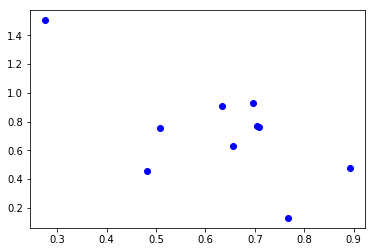

In [71]:
show_change(_X,_Y,_X,Y_makeup)